In [2]:
from lightgbm import LGBMRegressor

In [3]:
import pandas as pd
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split,KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
import xgboost as xgb

# Creating Dataset

In [958]:
%%time
data_demo = pd.read_csv('/home/abhijit/Downloads/log43_demo_converted.csv')
data_demo['time:timestamp'] = pd.to_datetime(data['time:timestamp']).dt.tz_localize(None)
data = pd.read_csv('/home/abhijit/Downloads/log43.csv')
data['time:timestamp'] = pd.to_datetime(data['time:timestamp']).dt.tz_localize(None)

CPU times: user 42.1 s, sys: 2.16 s, total: 44.2 s
Wall time: 44.2 s


In [852]:
data_demo = data_demo.groupby('case:concept:name').first().reset_index()[['Category','BU','case:concept:name','Priority']]

In [853]:
data = pd.merge(data,data_demo,on='case:concept:name',how='inner')

In [854]:
data = data[['case:concept:name','createdby','time:timestamp','Category','BU','Priority']]

In [855]:
data.head()

case:concept:name  createdby      time:timestamp Category    BU Priority
0              10000      411.0 2016-03-03 20:45:02    CAT_1  BU_1       P3
1              10000       57.0 2016-03-05 09:33:53    CAT_1  BU_1       P3
2              10000       57.0 2016-03-05 09:33:53    CAT_1  BU_1       P3
3              10000       57.0 2016-03-05 09:33:53    CAT_1  BU_1       P3
4              10000       57.0 2016-03-05 09:33:53    CAT_1  BU_1       P3

In [866]:
data[data['case:concept:name'] == 10000]['time:timestamp'].agg(lambda x: x.max() - x.min())/pd.Timedelta(1,'m')

2208.85

In [865]:
60 * 24 + 12 * 60 + 48

2208

In [868]:
def dataset_preprocessing(df, parameters=None):
    parameters = {} if parameters is None else parameters
    caseid_key = parameters['caseid_key'] if 'caseid_key' in parameters else 'case:concept:name'
    timestamp_key = parameters['timestamp_key'] if 'timestamp_key' in parameters else 'time:timestamp'
    case_duration = df[[caseid_key,timestamp_key]].groupby(caseid_key).agg(['min','max']).diff(axis=1).reset_index().droplevel(0,axis=1).rename(columns={'': caseid_key, 'max':'time_to_completion'}).drop(columns='min')
    case_duration['time_to_completion'] = round(case_duration['time_to_completion']/pd.Timedelta(1,'m'))
    df = pd.merge(df, case_duration, on=caseid_key, how='inner')
    df = df.groupby(caseid_key).first().reset_index()
    return df
    

In [869]:
data_final = dataset_preprocessing(data)

In [871]:
data_final.to_csv('/home/abhijit/Downloads/estimated_time_to_completion_minutes.csv', index=False)

In [1047]:
data_final['Priority'].value_counts()

P1    222434
P3     69766
P2     35579
Name: Priority, dtype: int64

# Model building

In [872]:
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline


In [4]:
data_ = pd.read_csv('/home/abhijit/Downloads/estimated_time_to_completion_minutes.csv')
data_['time:timestamp'] = pd.to_datetime(data_['time:timestamp']).dt.tz_localize(None)

In [5]:
data_ = data_[data_['Category']!='CAT_11']

In [7]:
data_.head()

case:concept:name  createdby      time:timestamp Category    BU Priority  \
0                 36      413.0 2016-01-30 15:35:01    CAT_5  BU_3       P3   
1                 66     2121.0 2016-02-01 01:57:03   CAT_10  BU_5       P3   
2                121        0.0 2016-02-01 06:10:11    CAT_1  BU_1       P3   
3                125       60.0 2016-02-01 07:45:16    CAT_1  BU_1       P3   
4                152        0.0 2016-02-01 08:25:01    CAT_1  BU_1       P3   

   time_to_completion  
0              2822.0  
1               759.0  
2            262249.0  
3               409.0  
4            287288.0

/home/abhijit/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


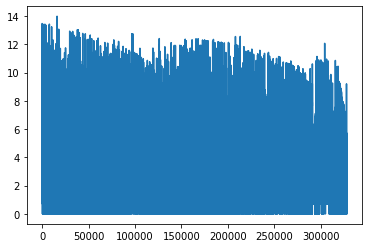

In [1400]:
plt.plot(np.log(data_['time_to_completion']))

In [1401]:
t = X_train['createdby'].value_counts().reset_index(name='counts')
t[t['counts'] <= 10000].shape

(683, 2)

In [1182]:
# data_['month'] = data_['time:timestamp'].dt.month
# data_['day'] = data_['time:timestamp'].dt.day
# data_['day_of_week'] = data['time:timestamp'].dt.dayofweek

In [1402]:
data_.head()

case:concept:name  createdby      time:timestamp Category    BU Priority  \
0                 36      413.0 2016-01-30 15:35:01    CAT_5  BU_3       P3   
1                 66     2121.0 2016-02-01 01:57:03   CAT_10  BU_5       P3   
2                121        0.0 2016-02-01 06:10:11    CAT_1  BU_1       P3   
3                125       60.0 2016-02-01 07:45:16    CAT_1  BU_1       P3   
4                152        0.0 2016-02-01 08:25:01    CAT_1  BU_1       P3   

   time_to_completion  
0              2822.0  
1               759.0  
2            262249.0  
3               409.0  
4            287288.0

In [1222]:
# data_['month_y'] = np.sin(2 * np.pi/12 * data_['month'])
# data_['month_x'] = np.cos(2 * np.pi/12 * data_['month'])

# data_['day_y'] = np.sin(2 * np.pi/31 * data_['day'])
# data_['day_x'] = np.cos(2 * np.pi/31 * data_['day'])

# data_['day_of_week_y'] = np.sin(2 * np.pi/6 * data_['day_of_week'])
# data_['day_of_week_x'] = np.cos(2 * np.pi/6 * data_['day_of_week'])



In [1377]:
# cols = {col:data_[col].dtype for col in data_.columns}
# columns_to_include = [col for col in list(cols.keys()) if cols[col]=='float' or cols[col]=='object']

In [1427]:
def data_preprocessing(df, columns_to_include, parameters=None):
    timestamp_key = parameters['timestamp_key'] if 'timestamp_key' in parameters else 'time:timestamp'
    caseid_key = parameters['caseid_key'] if 'caseid_key' in parameters else 'case:concept:name'
    target_key = parameters['target_key'] if 'target_key' in parameters else 'time_to_completion'
    df['month'] = df['time:timestamp'].dt.month
    df['day'] = df['time:timestamp'].dt.day
    df['day_of_week'] = df['time:timestamp'].dt.dayofweek
    
    df['month_y'] = np.sin(2 * np.pi/12 * df['month'])
    df['month_x'] = np.cos(2 * np.pi/12 * df['month'])

    df['day_y'] = np.sin(2 * np.pi/31 * df['day'])
    df['day_x'] = np.cos(2 * np.pi/31 * df['day'])

    df['day_of_week_y'] = np.sin(2 * np.pi/6 * df['day_of_week'])
    df['day_of_week_x'] = np.cos(2 * np.pi/6 * df['day_of_week'])
    df.drop(columns=['month','day','day_of_week'], inplace=True)

    cols = {col:df[col].dtype for col in df.columns}
    columns_to_inclue = [col for col in list(cols.keys()) if cols[col]=='float' or cols[col]=='object']
    X = df[columns_to_include] 
    X.drop(columns=[target_key], inplace=True)
    y = target_transform(df[target_key])
    column_trans = make_column_transformer(
                    (OneHotEncoder(), list(X.select_dtypes('object').columns)),
                    remainder='passthrough')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    target_thresh = target_transform(parameters['target_thresh']) if 'target_thresh' in parameters else y_train.quantile(0.95)
    print(f'target_thresh: {target_thresh}, train_quantile: {y_train.quantile(0.95)}')
    y_train,train_idx = y_train[y_train < target_thresh],np.asarray(y_train.index[y_train < target_thresh])
    X_train = X_train.loc[train_idx]
    y_test, test_idx = y_test[y_test < target_thresh], np.asarray(y_test.index[y_test < target_thresh])
    X_test = X_test.loc[test_idx]
    return X_train, X_test, y_train, y_test, column_trans

def target_transform(y):
    return np.log(y + 1)

def inverse_target_transform(y):
    return np.exp(y) - 1

In [1428]:
def train(X,y, column_trans): 
    
    #column_trans.fit_transform(X)
    #rf = RandomForestRegressor(n_jobs=-1,n_estimators=130,max_depth=12)
    xgbr = xgb.XGBRegressor(n_jobs=-1, n_estimators=110, max_depth=11,
                            learning_rate=0.07,
                            gamma=0.2, eta=0.1,
                            booster='dart',
                            alpha=0.8,
                            reg_lambda=0.3)
    pipeline = Pipeline([('transformations', column_trans), ('xgbr', xgbr)], verbose=True)
#     params = {
#         'xgbr__n_estimators': np.arange(100,150,5),
#         'xgbr__max_depth': np.arange(3,15,1),
#         'xgbr__booster': ['gbtree','dart'],
#         'xgbr__learning_rate': [.03, 0.05, .07,0.1],
#         'xgbr__eta': np.arange(0.1,1, 0.05),
#         'xgbr__gamma': np.arange(0.1,1,0.1),
#         'xgbr__lambda': np.arange(0.1,1,0.1),
#         'xgbr__alpha': np.arange(0.1,1,0.1)
#     }
#     model = RandomizedSearchCV(
#                 estimator = pipeline,
#                 param_distributions=params,
#                 verbose=10, n_jobs=-1, cv=5)
#     model.fit(X,y)
    print(f'input: {X.iloc[0]}')
    print(f'target: {y.iloc[0]}')
    pipeline.fit(X, y)
    #print(f'best score: {model.best_score_}, \n best parameters: {model.best_params_}')
    
    return pipeline

In [1429]:
%%time
X_train, X_test, y_train, y_test, column_trans = data_preprocessing(data_, columns_to_include, parameters={
    'target_thresh': 50*60})
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
pipeline_model = train(X_train, y_train, column_trans)

/home/abhijit/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


target_thresh: 8.006700845440367, train_quantile: 7.934871565945177
(209375, 10) (103183, 10) (209375,) (103183,)
input: createdby                  0
Category               CAT_5
BU                      BU_3
Priority                  P3
month_y                   -1
month_x         -1.83697e-16
day_y               0.299363
day_x              -0.954139
day_of_week_y    1.22465e-16
day_of_week_x             -1
Name: 146640, dtype: object
target: 6.561030665896573
[Pipeline] ... (step 1 of 2) Processing transformations, total=   0.3s
[Pipeline] .............. (step 2 of 2) Processing xgbr, total= 5.5min
CPU times: user 5min 29s, sys: 62.8 ms, total: 5min 30s
Wall time: 5min 30s


In [1430]:
preds = pipeline_model.predict(X_test)
actual = y_test.to_numpy()

In [1431]:
# %%time
# cv = KFold(n_splits=12)
# np.mean(inverse_target_transform(-1 * cross_val_score(pipeline_model, X_test, y_test, cv=cv, scoring='neg_mean_absolute_error' )))

In [1432]:
mean_absolute_error(inverse_target_transform(pipeline_model.predict(X_train)),inverse_target_transform(y_train))

248.0197420659384

In [1433]:
mean_absolute_error(inverse_target_transform(pipeline_model.predict(X_test)), inverse_target_transform(y_test))

261.30960596501205

In [1434]:
idx = np.random.choice(len(y_test), 20)
idx

array([102470,  50798,  99426,  35611,  18110,   1712,  17465,  12914,
        58492,  60555,  54208,  20034,   9091,  12618,  93392,  95302,
         6091,  62917,  27886,  47996])

In [1435]:
inverse_target_transform(y_test.to_numpy()[idx])

array([ 28.,  69.,  42., 140., 312.,   6., 194.,   8.,  74.,  31.,  12.,
       144.,   6., 105., 100., 269., 367., 365.,  41., 414.])

In [1436]:
np.rint(inverse_target_transform(preds[idx]))

array([ 40.,  28.,  21.,  42., 633.,  24., 206.,  21.,  31.,  53.,  28.,
        45.,  23.,  26.,  25., 211., 884., 606.,  18., 623.],
      dtype=float32)

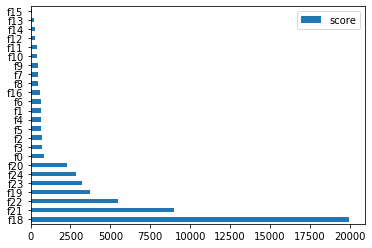

In [1437]:
feature_important = pipeline_model[1].get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.plot(kind='barh')